In [6]:
# # Split Dataset

# import os
# import shutil

# original_dataset_dir = '/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/mvtec88_aug'
# classes_list = os.listdir(original_dataset_dir)

# base_dir = '/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted_aug'
# os.mkdir(base_dir)

# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# # train,validation,test 폴더 하위에 각각 클래스 목록 폴더 생성
# for clss in classes_list:
#     os.mkdir(os.path.join(train_dir,clss))
#     os.mkdir(os.path.join(test_dir,clss))
    

# # [데이터 분할과 클래스별 데이터 수 확인]
# import math

# for clss in classes_list:
#     path = os.path.join(original_dataset_dir,clss)
#     fnames = os.listdir(path)
    
#     train_size = math.floor(len(fnames)*0.8)
#     test_size = math.floor(len(fnames)*0.2)
    
#     train_fnames = fnames[:train_size]
#     print('Train size(',clss,'): ', len(train_fnames))
#     for fname in train_fnames:
#         src = os.path.join(path, fname)
#         dst = os.path.join(os.path.join(train_dir, clss), fname)
#         shutil.copyfile(src,dst)
        
#     test_fnames = fnames[train_size:(train_size+test_size)]
#     print('Test size(',clss,'): ', len(test_fnames))
#     for fname in test_fnames:
#         src = os.path.join(path, fname)
#         dst = os.path.join(os.path.join(test_dir, clss),fname)
#         shutil.copyfile(src,dst)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted_aug/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted_aug/test', transform=transform)

/home/iai/anaconda3/envs/jwanaconda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# import os
# import glob
# import torchvision.transforms as transforms
# from PIL import Image

# # Define augmentation transfoㅁrms
# augmentation_transforms = transforms.Compose([
#     transforms.ColorJitter(),
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor()
#     ])


# for class_name in train_dataset.classes:
#     if 'good' in class_name:
#         continue
#     class_path = os.path.join(train_dataset.root, class_name)
#     image_paths = glob.glob(os.path.join(class_path, '*.png')) # Get a list of image paths using glob.glob()
#     for i in range(10):
#         img_num = 10000
#         for image_path in image_paths:
#             image = Image.open(image_path)
#             augmented_image = augmentation_transforms(image)
#             augmented_image_path = os.path.join(class_path, f'{i}_{os.path.basename(image_path)}')
#             torchvision.utils.save_image(augmented_image, augmented_image_path)
#         img_num += 1

In [2]:
import torch.nn as nn
from torchvision.models import resnet18

# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=88):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ResNet18(num_classes=88).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, optimizer, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [3]:
# Active learning loop
from sklearn.metrics import precision_recall_fscore_support

test_loss_1000 = []
test_precision_1000 = []
test_recall_1000 = []
test_f1_1000 = []

num_initial_samples = 1000
num_queries = int(len(train_dataset) / 1000) # 14
batch_size = 1

# Define initial labeled dataset
labeled_indices = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)

unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:1000]
unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

# Define data loaders
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


for query in range(num_queries+1):
    print("Query number:", query+1)
    
    # Train model on labeled dataset
    train_loss, train_acc = train(model, optimizer, labeled_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print("Length of labeled dataset : ",len(labeled_dataset))
    

    # Evaluate model on test dataset
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        test_loss_1000.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=1)
        test_precision_1000.append(precision)
        test_recall_1000.append(recall)
        test_f1_1000.append(f1)
        print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")
    
    # Make model predictions on unlabeled dataset
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader:
            images = images.to(device)
            output = model(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)
    
    if query == (num_queries):
        break

    # # Select samples to label using entropy-based method
    # entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    # _, idx = torch.topk(entropy, k=batch_size * 3)
    # labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])
    # unlabeled_indices = unlabeled_indices[~torch.eq(unlabeled_indices.unsqueeze(1), unlabeled_indices[idx]).any(1)]
    
    # 엔트로피가 0.5 이상인 인덱스를 선택
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    idx = torch.where(entropy >= 0.5)[0].to(device)
    # check if indices are empty
    if idx.numel() == 0:
        continue
    # concatenate selected indices to labeled dataset indices
    labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])

    # Update labeled and unlabeled datasets
    if len(train_dataset)-(query+1)*1000 > 1000:
        unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:1000]
    else:
        unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)][:len(train_dataset)-14000]
    labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)
    print("Updated Length of labeled dataset : ",len(labeled_dataset))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset))

    # Update labeled and unlabeled data loaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

Query number: 1
Train Loss: 2.9276, Train Accuracy: 0.2400
Length of labeled dataset :  1000
Test Loss: 4.8410, Test Accuracy: 0.0377
Test Precision: 0.3595, Test Recall: 0.0377, Test F1 Score: 0.0277
Updated Length of labeled dataset :  1602
Length of unlabeled dataset :  1000
Query number: 2
Train Loss: 4.2137, Train Accuracy: 0.0805
Length of labeled dataset :  1602
Test Loss: 5.0790, Test Accuracy: 0.0129
Test Precision: 0.9507, Test Recall: 0.0129, Test F1 Score: 0.0005
Updated Length of labeled dataset :  2602
Length of unlabeled dataset :  1000
Query number: 3
Train Loss: 3.2990, Train Accuracy: 0.1264
Length of labeled dataset :  2602
Test Loss: 4.3904, Test Accuracy: 0.0360
Test Precision: 0.8498, Test Recall: 0.0360, Test F1 Score: 0.0164
Updated Length of labeled dataset :  3577
Length of unlabeled dataset :  1000
Query number: 4
Train Loss: 2.5670, Train Accuracy: 0.1951
Length of labeled dataset :  3577
Test Loss: 3.9854, Test Accuracy: 0.0988
Test Precision: 0.8295, Test 

In [4]:
print(test_f1_1000)

[0.02773893956147527, 0.0004800082655830661, 0.016353379491431768, 0.06059874987632454, 0.08935936127885057, 0.10721654639605002, 0.1540812242102851, 0.1751623678679521, 0.1876042579550329, 0.23650343448130884, 0.24052291502510798, 0.26030266956173154, 0.24169957661121977, 0.21587716304640409, 0.2507764605513968]


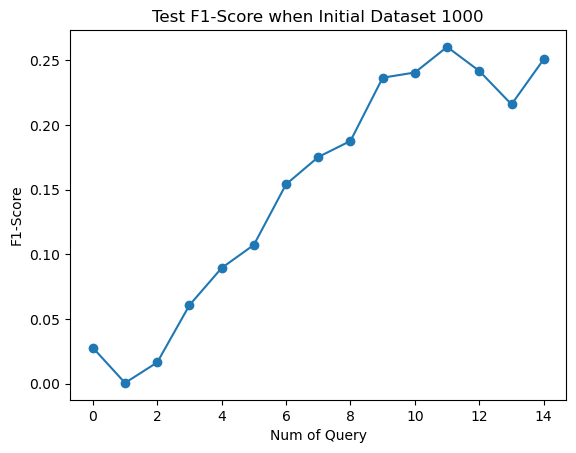

In [5]:
from matplotlib import pyplot as plt 

plt.plot(test_f1_1000, marker = 'o')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('Test F1-Score when Initial Dataset 1000')
plt.show()

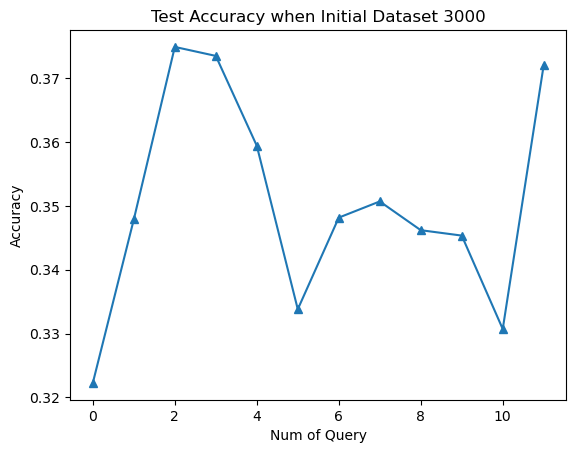

In [ ]:
plt.plot(test_f1_3000, marker = '^')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('Test F1-Score when Initial Dataset 3000')
plt.show()

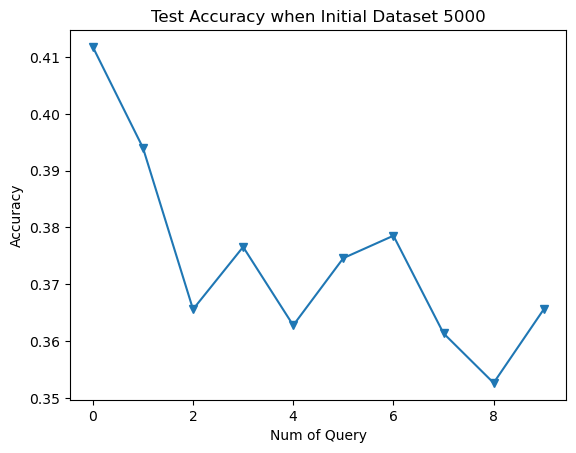

In [ ]:
plt.plot(test_f1_5000, marker = 'v')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('Test F1-Score when Initial Dataset 5000')
plt.show()

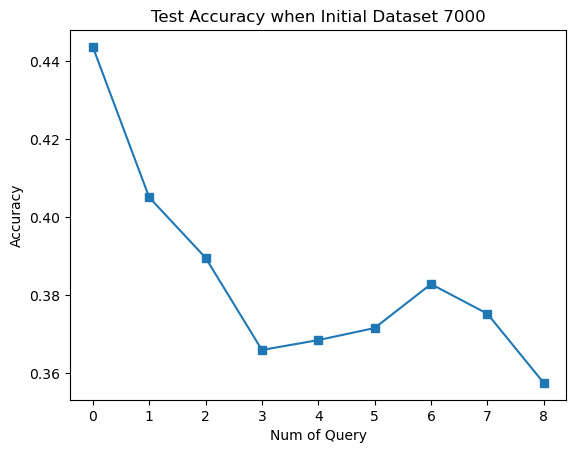

In [ ]:
plt.plot(test_f1_7000, marker = 's')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('Test F1-Score when Initial Dataset 7000')
plt.show()

In [ ]:
total_test_f1 = []
total_test_f1.append(test_f1_1000[-1])
total_test_f1.append(test_f1_3000[-1])
total_test_f1.append(test_f1_5000[-1])
total_test_f1.append(test_f1_7000[-1])

print(total_test_f1)

[0.34027582324795946, 0.3720799324514495, 0.365606529693217, 0.35744441317196735]
